# THR-Exploration

Import data and conduct experiments to answer questions about ALL/AML correlation within THR sources

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import re
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from utils import *

In [3]:
%%time
corr_df = load_tsv('/data/archive/compendium/v5/v5_all_by_all.2018-02-04.tsv')
meta_df = load_tsv('/data/archive/compendium/v5/clinical.tsv')
prep_df = load_tsv('~/work/TURG/resources/TreehouseCompendiumSamples_LibraryPrep.tsv')
type_df = pd.read_csv('~/work/TURG/resources/DiseaseAnnotations_2018-04_Labels.csv', sep=',', index_col=1)

CPU times: user 1min 43s, sys: 24.5 s, total: 2min 7s
Wall time: 2min 7s


### How correlated are other ALL samples with AML?

Specifically, what impact does RiboD preparation have on their correlation? Use the `type_df` to find ALL samples of interest.

This section is the only one where preparation type matters, as in every other case I search only in the correlation matrix which contains only PolyA-prepared samples.

In [90]:
samples_with_ALL = get_samples_by_disease(ALL, type_df, meta_df)

Number of donors missing from file structure: 150


In [224]:
%%time
fracs_aml = pd.Series()
sources = pd.Series()
prep_types = pd.Series()
corr_fracs = {
    'TCGA': pd.Series(),
    'THR': pd.Series(),
    'TARGET': pd.Series(),
    'TH': pd.Series()}
aml_fracs = {
    'TCGA': pd.Series(),
    'THR': pd.Series(),
    'TARGET': pd.Series(),
    'TH': pd.Series()}

for sample_id in samples_with_ALL:
    
    # sources
    source = sample_to_source(sample_id)
    sources[sample_id] = source
    
    # prep_types
    sample_prep = prep_df.loc[sample_id]['libSelType']
    if type(sample_prep) == pd.Series:
        sample_prep = sample_prep.iloc[0]
    prep_types[sample_id] = sample_prep
    
    # get correlated diseases
    sample_ids = get_samples_correlated_above_threshold(sample_id, corr_df)
    if sample_ids is None:
        continue
    
    # filter for only ones from the same source
    source = sample_to_source(sample_id)
    sample_ids = [s for s in sample_ids if sample_to_source(s) == source]
    
    donor_ids = [sample_to_donor(sample_id) for sample_id in sample_ids]
    disease_counts = type_df.loc[donor_ids]['Diagnosis/Disease'].value_counts()
    disease_distrib = disease_counts / sum(disease_counts)
    
    fracs_aml[sample_id] = disease_distrib[AML] if AML in disease_distrib else 0.0

    # corr_fracs & aml_fracs
    corr_sources = Counter([re.match(r'[a-zA-Z]+', s).group() for s in sample_ids])
    for src in src_fracs.keys():
        corr_fracs[src][sample_id] = corr_sources[src] / sum(corr_sources.values()) if src in corr_sources else 0.0
    
    aml_samples = [s for s in sample_ids if meta_df.loc[s]['disease'] == AML]
    aml_sources = Counter([re.match(r'[a-zA-Z]+', s).group() for s in aml_samples])
    for src in src_fracs.keys():
        aml_fracs[src][sample_id] = aml_sources[src] / sum(aml_sources.values()) if src in aml_sources else 0.0

CPU times: user 19.9 s, sys: 420 ms, total: 20.3 s
Wall time: 20.7 s


In [225]:
corr_fracs = {'frac_'+src: col for src, col in corr_fracs.items()}
aml_fracs = {'aml_frac_'+src: col for src, col in aml_fracs.items()}

samples_df = pd.DataFrame({'frac_AML': fracs_aml, 'source': sources, 'prep_type': prep_types,
                           **corr_fracs, **aml_fracs})
samples_df.index.name = 'THid'
samples_df = samples_df[pd.notnull(samples_df['frac_AML'])]

In [226]:
THR_df = samples_df[samples_df['source'] == 'THR']

In [227]:
palette = sb.color_palette(n_colors=10)
color_1 = palette[0]

In [228]:
THR_df.head()

,aml_frac_TARGET,aml_frac_TCGA,aml_frac_TH,aml_frac_THR,frac_AML,frac_TARGET,frac_TCGA,frac_TH,frac_THR,prep_type,source
THid,,,,,,,,,,,
THR08_0161_S01,0.0,0.0,0.0,1.0,0.130435,0.0,0.0,0.0,1.0,polyASelection,THR
THR08_0161_S02,0.0,0.0,0.0,1.0,0.147541,0.0,0.0,0.0,1.0,polyASelection,THR
THR08_0162_S01,0.0,0.0,0.0,1.0,0.130435,0.0,0.0,0.0,1.0,polyASelection,THR
THR08_0162_S02,0.0,0.0,0.0,1.0,0.138889,0.0,0.0,0.0,1.0,polyASelection,THR
THR08_0163_S01,0.0,0.0,0.0,1.0,0.132353,0.0,0.0,0.0,1.0,polyASelection,THR


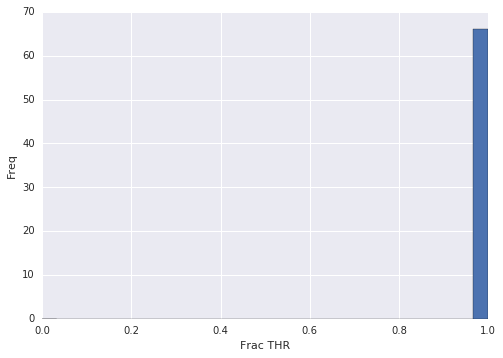

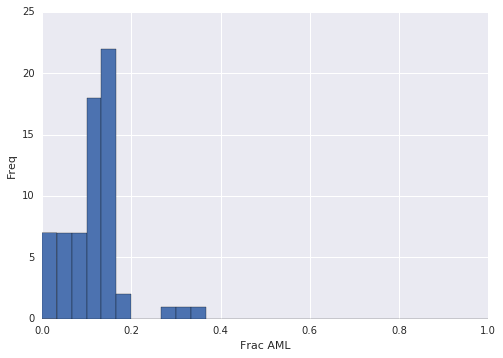

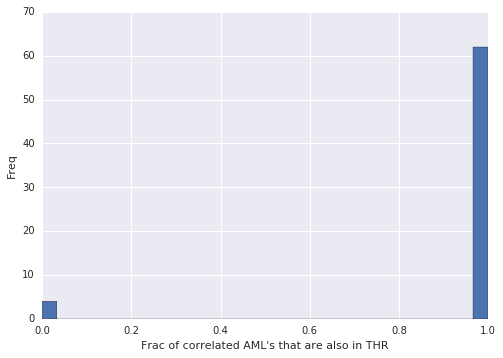

In [229]:
plt.hist(THR_df['frac_THR'], bins=30, range=(0, 1), color=color_1, alpha=1.0)
plt.xlabel('Frac THR')
plt.ylabel('Freq')
plt.show()

plt.hist(THR_df['frac_AML'], bins=30, range=(0, 1), color=color_1, alpha=1.0)
plt.xlabel('Frac AML')
plt.ylabel('Freq')
plt.show()

plt.hist(THR_df['aml_frac_THR'], bins=30, range=(0, 1), color=color_1, alpha=1.0)
plt.xlabel('Frac of correlated AML\'s that are also in THR')
plt.ylabel('Freq')
plt.show()

In [230]:
sub_sources = pd.Series()
for sample in samples_with_ALL:
    m = re.search(r'[0-9][0-9]', sample)
    sub_src = sample[m.start():m.end()]
    sub_sources[sample] = sub_src
samples_df['sub_source'] = sub_sources

In [231]:
def plot_criterion(df, criterion=None, title=None, range=(0, 1), color='blue', alpha=1.0, label=''):
    src_df = df if criterion is None else df.loc[criterion]
    plt.hist(src_df['frac_AML'], bins=30, range=range, color=color, alpha=alpha, label=label)
    if title is not None:
        plt.title(title)
    plt.xlabel('Frac AML')
    plt.ylabel('Freq')

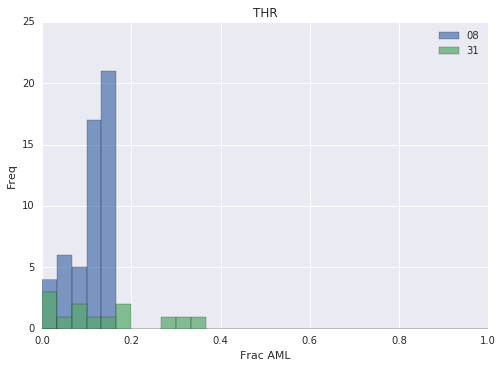

In [232]:
src_constraint = samples_df['source'] == 'THR'
sub_srcs = samples_df.loc[src_constraint]['sub_source'].unique()
constraints = {sub_src: (src_constraint & (samples_df['sub_source'] == sub_src)) for sub_src in sub_srcs}

for i, (subsrc, constraint) in enumerate(constraints.items()):
    plot_criterion(samples_df, constraint, title='THR', color=palette[i], alpha=0.7, label=subsrc)
    plt.legend(loc='upper right')
plt.show()

In the study that produced the samples from THR08, they note that 47 of the total had the MLL mutation, and 18 did not. This cell investigates whether there appear to be two clusters of size proportional to the MLL mutation/non-mutation classes within the AMLness histogram. Because we only have 53 ALL samples from THR08, I color the first 18 / (18 + 47) blue, and the rest green.

Result: two clusters do appear to form.

In [243]:
frac_aml_series = samples_df[samples_df['source'] == 'TARGET']['frac_AML'].sort_values(ascending=False)
print('Top 15 ALL samples by AMLness out of 280')
frac_aml_series.iloc[:15]

Top 15 ALL samples by AMLness out of 280


THid
TARGET-10-PARMXF-04    0.855670
TARGET-10-PAPZST-04    0.789474
TARGET-10-PANUSN-04    0.719212
TARGET-10-PAPHEK-03    0.693878
TARGET-10-PARGML-03    0.512821
TARGET-10-PAPZST-09    0.511737
TARGET-10-PARLEK-03    0.438144
TARGET-10-PAPSPG-04    0.425532
TARGET-10-PANJWJ-09    0.399177
TARGET-10-PANZPJ-04    0.395062
TARGET-10-PARJZZ-04    0.372093
TARGET-10-PARUBK-03    0.362573
TARGET-10-PANJPG-09    0.351779
TARGET-10-PAPIGX-09    0.343915
TARGET-10-PAPBFN-09    0.340426
Name: frac_AML, dtype: float64

In [255]:
# sample_id = 'TH01_0123_S01'
# sample_id = 'THR08_0170_S01'
sample_id = 'TARGET-10-PARMXF-04'
# sample_id = 'TARGET-20-PARTAL-04'
sample_corrs = pd.Series(get_sample_correlations(sample_id, corr_df))
top_percent = sample_corrs[sample_corrs > 0.87].sort_values(ascending=False)
print(len(top_percent))
# print(frac_aml_series[sample_id])
print(top_percent[:40].to_string())

140
TARGET-10-PARMXF-04    1.000000
TARGET-20-PASTUH-03    0.910344
TARGET-20-PADYIR-09    0.907019
TARGET-20-PARSHM-03    0.904924
TARGET-20-PARTAL-04    0.901704
TCGA-AB-2981-03        0.901131
TARGET-20-PARDMG-09    0.899815
TARGET-20-PASYJI-04    0.898054
TCGA-AB-2987-03        0.897718
TARGET-20-PARYFN-04    0.897594
TARGET-20-PARUDL-03    0.897412
TARGET-20-PARFAL-04    0.896628
TARGET-20-PANPLS-03    0.894987
TARGET-20-PARWDZ-09    0.893257
TARGET-20-PARTAL-09    0.892334
TH03_0285_S01          0.892253
TARGET-20-PAEERJ-04    0.892253
TARGET-20-PAEIKD-09    0.891498
TARGET-20-PARSAN-03    0.891302
TARGET-20-PAKIWK-09    0.891110
TARGET-20-PAECCE-09    0.890634
TCGA-AB-2836-03        0.890428
TARGET-20-PASGGK-03    0.890276
TCGA-AB-2851-03        0.889906
TCGA-AB-2916-03        0.889726
TARGET-20-PAPVDV-03    0.889722
TARGET-20-PASXNR-04    0.889625
TARGET-20-PANPKN-09    0.888974
TARGET-20-PARIMT-03    0.888790
TARGET-20-PASVYA-09    0.888543
TARGET-20-PALGKX-04    0.887567
TCGA

In [256]:
print(meta_df['disease'].loc[top_percent.index].to_string())

TARGET-10-PARMXF-04        acute lymphoblastic leukemia
TARGET-20-PASTUH-03              acute myeloid leukemia
TARGET-20-PADYIR-09              acute myeloid leukemia
TARGET-20-PARSHM-03              acute myeloid leukemia
TARGET-20-PARTAL-04              acute myeloid leukemia
TCGA-AB-2981-03                  acute myeloid leukemia
TARGET-20-PARDMG-09              acute myeloid leukemia
TARGET-20-PASYJI-04              acute myeloid leukemia
TCGA-AB-2987-03                  acute myeloid leukemia
TARGET-20-PARYFN-04              acute myeloid leukemia
TARGET-20-PARUDL-03              acute myeloid leukemia
TARGET-20-PARFAL-04              acute myeloid leukemia
TARGET-20-PANPLS-03              acute myeloid leukemia
TARGET-20-PARWDZ-09              acute myeloid leukemia
TARGET-20-PARTAL-09              acute myeloid leukemia
TH03_0285_S01          juvenile myelomonocytic leukemia
TARGET-20-PAEERJ-04              acute myeloid leukemia
TARGET-20-PAEIKD-09              acute myeloid l

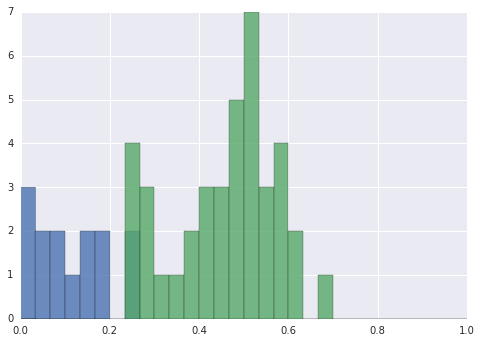

In [152]:
frac_aml_thr08 = samples_df[src_constraint & (samples_df['sub_source'] == '08')]['frac_AML']
frac_aml_list = sorted(list(frac_aml_thr08))
total = len(frac_aml_list)
non_mll = int(total * 18 / (18 + 47))
plt.hist(frac_aml_list[:non_mll], range=(0, 1), bins=30, alpha=0.8)
plt.hist(frac_aml_list[non_mll:], range=(0, 1), bins=30, alpha=0.8)
plt.show()

However, the paper also notes that overall we expect around 80% of ALL samples to have the MLL variation. As a result, this bimodality should transfer over to the samples from TARGET, but it does not, so another explanation is needed.

# Extra Cells

In [ ]:
sub_sources = pd.Series()
for sample in samples_with_ALL:
    m = re.search(r'[0-9][0-9]', sample)
    sub_src = sample[m.start():m.end()]
    sub_sources[sample] = sub_src
samples_df['sub_source'] = sub_sources

In [ ]:
src_constraint = samples_df['source'] == 'THR'
sub_srcs = samples_df.loc[src_constraint]['sub_source'].unique()
constraints = {sub_src: (src_constraint & (samples_df['sub_source'] == sub_src)) for sub_src in sub_srcs}

for i, (subsrc, constraint) in enumerate(constraints.items()):
    plot_criterion(samples_df, constraint, title='THR', color=palette[i], alpha=0.7, label=subsrc)
    plt.legend(loc='upper right')
plt.show()